In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from one_step_thoughtsformer import ThoughtsFormer
import matplotlib.pyplot as plt

In [16]:
from x import GPT
from transformers import GPT2LMHeadModel

# create a from-scratch initialized minGPT model
config = GPT.get_default_config()
config.model_type = "gpt2"
config.vocab_size = 50257 # openai's model vocabulary
config.block_size = 1024  # openai's model block_size
model = GPT(config)
sd = model.state_dict()

sd = {x: y for x, y in sd.items() if ".attn.bias" not in x}
# init a huggingface/transformers model
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

# copy while ensuring all of the parameters are aligned and match in names and shapes
keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] # ignore these
transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
# basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla nn.Linear.
# this means that we have to transpose these weights when we import them
print(sorted(keys))
print(sorted(sd))

number of parameters: 124.44M
['lm_head.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.10.attn.c_attn.bias', 'transformer.h.10.attn.c_attn.weight', 'transformer.h.10.attn.c_proj.bias', 'transformer.h.10.attn

In [59]:
from x import GPT
model = GPT.from_pretrained('gpt2')
from transformers import GPT2Tokenizer

t = GPT2Tokenizer.from_pretrained("gpt2-medium")

next_token = ""
sentence = "Once upon a time, "
inp_tokens = t.encode(sentence,  return_tensors='pt')
for i in range(10):
    sentence += next_token
    
    prediction = model(inp_tokens)[0][:,-1,:].argmax(dim=-1).unsqueeze(-1)
 
    # print(tokens.shape)
    # predictions = model(tokens)[0]
    # print(predictions)
    # x = predictions.argmax(dim=-1)

    inp_tokens = torch.cat([inp_tokens, prediction], dim=-1)

    print(t.decode(inp_tokens[0]))

number of parameters: 124.44M


AssertionError: 

In [46]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained("gpt2").eval()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate(prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
        next_token_id = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(-1)
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)
        print(tokenizer.decode(input_ids[0], skip_special_tokens=True))
        if next_token_id.item() == tokenizer.eos_token_id:
            break

generate("Once upon a time, in a land far away,")

c:\Users\bicke\anaconda3\envs\megatron\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Once upon a time, in a land far away, the
Once upon a time, in a land far away, the world
Once upon a time, in a land far away, the world was
Once upon a time, in a land far away, the world was a
Once upon a time, in a land far away, the world was a land
Once upon a time, in a land far away, the world was a land of
Once upon a time, in a land far away, the world was a land of peace
Once upon a time, in a land far away, the world was a land of peace and
Once upon a time, in a land far away, the world was a land of peace and harmony
Once upon a time, in a land far away, the world was a land of peace and harmony.
Once upon a time, in a land far away, the world was a land of peace and harmony. The
Once upon a time, in a land far away, the world was a land of peace and harmony. The world
Once upon a time, in a land far away, the world was a land of peace and harmony. The world was
Once upon a time, in a land far away, the world was a land of peace and harmony. The world was a
Once upon a ti

161


In [24]:
from one_step_thoughtsformer import ThoughtsFormer
import torch
import math

max_context = 10
batch_size, max_seq_len, d_embed = 2, 20, 6
thought_length = 1
seq_len = 3
thoughts_this_time = 1

a = torch.arange(seq_len * (thoughts_this_time+1)).view(seq_len * (thoughts_this_time+1),1).repeat(1,d_embed)
b = F.pad(torch.arange(2).view(2,1).repeat(1,d_embed), (0,0,0,4))
test_embeds = torch.stack((a,b), dim=0)
# test_embeds = torch.ones(batch_size, (thoughts_this_time+1)*seq_len,d_embed)
# print(test_embeds)
# y = simple_batched_reshape_with_offset(test_embeds,seq_length=5, offset=thoughts_this_time+1,row_length=thought_length + 1, pad_value=0)
# print(y, y.shape)


# print(test_embeds.shape)
padding_mask = torch.zeros(batch_size, 5)
x = ThoughtsFormer(thought_length=thought_length, vocab_size=30000, max_context_length=max_context, d_embed=6,n_head=2, num_layers=3, verbose=False, sinusoidal_position_encoding=False,dropout=0)
[s for s in x.state_dict().keys()]
# x.forward_ppo(test_embeds,padding_mask,thoughts_this_time)[1]

['transformer.dual_positional_encoding.learned_positional_encoding.weight',
 'transformer.dual_positional_encoding.position_in_thought_encoding.weight',
 'transformer.transformer.layers.0.self_attn.in_proj_weight',
 'transformer.transformer.layers.0.self_attn.in_proj_bias',
 'transformer.transformer.layers.0.self_attn.out_proj.weight',
 'transformer.transformer.layers.0.self_attn.out_proj.bias',
 'transformer.transformer.layers.0.linear1.weight',
 'transformer.transformer.layers.0.linear1.bias',
 'transformer.transformer.layers.0.linear2.weight',
 'transformer.transformer.layers.0.linear2.bias',
 'transformer.transformer.layers.0.norm1.weight',
 'transformer.transformer.layers.0.norm1.bias',
 'transformer.transformer.layers.0.norm2.weight',
 'transformer.transformer.layers.0.norm2.bias',
 'transformer.transformer.layers.1.self_attn.in_proj_weight',
 'transformer.transformer.layers.1.self_attn.in_proj_bias',
 'transformer.transformer.layers.1.self_attn.out_proj.weight',
 'transformer.tr

In [31]:
print(*[s for s in sorted(keys)], sep="\n")

lm_head.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.ln_1.bias
transformer.h.0.ln_1.weight
transformer.h.0.ln_2.bias
transformer.h.0.ln_2.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.ln_1.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_2.bias
transformer.h.1.ln_2.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.10.attn.c_attn.bias
transformer.h.10.attn.c_attn.weight
transformer.h.10.attn.c_proj.bias
transformer.h.10.attn.c_proj.weight
transformer.h.10.ln_1.bias
transformer.h.10.ln_1.weight
transformer.h.10.ln_2.bias
transformer.h.10.l

In [4]:
thoughtsformer = ThoughtsFormer(num_layers=12,vocab_size=50257, d_embed = 768, feed_forward_dim=768 * 4, n_head=12, max_context_length=1024, thought_length=0,sinusoidal_position_encoding=False)
[s for s in thoughtsformer.state_dict().keys() if "transformer.dual_positional_encoding.position_in_thought_encoding.weight" != s and "value" not in s]


# mapping = {
#     'transformer.dual_positional_encoding.learned_positional_encoding.weight': 'transformer.wpe.weight',
#     'token_embedding.weight' : 'transformer.wte.weight',
#      'transformer.transformer.norm.weight' : 'transformer.ln_f.weight',
#      'transformer.transformer.norm.bias' : 'transformer.ln_f.bias'
# }

# for i in range(12):
#     mapping[f'transformer.transformer.layers.{i}.self_attn.in_proj_weight'] = 

['transformer.dual_positional_encoding.learned_positional_encoding.weight',
 'transformer.transformer.layers.0.self_attn.in_proj_weight',
 'transformer.transformer.layers.0.self_attn.in_proj_bias',
 'transformer.transformer.layers.0.self_attn.out_proj.weight',
 'transformer.transformer.layers.0.self_attn.out_proj.bias',
 'transformer.transformer.layers.0.linear1.weight',
 'transformer.transformer.layers.0.linear1.bias',
 'transformer.transformer.layers.0.linear2.weight',
 'transformer.transformer.layers.0.linear2.bias',
 'transformer.transformer.layers.0.norm1.weight',
 'transformer.transformer.layers.0.norm1.bias',
 'transformer.transformer.layers.0.norm2.weight',
 'transformer.transformer.layers.0.norm2.bias',
 'transformer.transformer.layers.1.self_attn.in_proj_weight',
 'transformer.transformer.layers.1.self_attn.in_proj_bias',
 'transformer.transformer.layers.1.self_attn.out_proj.weight',
 'transformer.transformer.layers.1.self_attn.out_proj.bias',
 'transformer.transformer.layers

In [17]:
a = torch.tensor([
    [1,2,0,0],
    [3,4,0,0]]).unsqueeze(0).unsqueeze(3).permute(0,2,1,3)

a.reshape(1,-1,1)

tensor([[[1],
         [3],
         [2],
         [4],
         [0],
         [0],
         [0],
         [0]]])

In [5]:
import torch.nn as nn

def print_model_parameters(model):
    """
    Print all parameters of a PyTorch model.
    
    Args:
    model (nn.Module): The PyTorch model to analyze
    
    Returns:
    None: Prints information to stdout
    """
    print(f"Model: {model.__class__.__name__}")
    print("=" * 50)
    
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}")
            print(f"Shape: {param.shape}")
            print(f"Number of parameters: {param.numel()}")
            print("-" * 30)
            total_params += param.numel()
    
    print("=" * 50)
    print(f"Total trainable parameters: {total_params}")
vocab_size = 50257  # GPT-2 tokenizer vocabulary size
d_embed = 768  # Embedding dimension
epochs = 30
max_sequence_length = 1000
chunk_size = 200  # New sequence chunk size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = CausalModel(vocab_size, max_sequence_length=chunk_size, num_layers=12, feed_forward_dim=d_embed*4, dropout=0.15).to(device)
thoughtsformer = ThoughtsFormer(thought_length=0, vocab_size= vocab_size, max_sequence_length=chunk_size, verbose=False, num_layers=5, dropout=0.15).to(device)

# print_model_parameters(model)
# print()
# print()
# print()
# print("\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
# print()
# print()
# print()
print_model_parameters(thoughtsformer)

Model: ThoughtsFormer
Layer: transformer.positional_encoding.thought_position_encoding.weight
Shape: torch.Size([1, 768])
Number of parameters: 768
------------------------------
Layer: transformer.layer.self_attn.in_proj_weight
Shape: torch.Size([2304, 768])
Number of parameters: 1769472
------------------------------
Layer: transformer.layer.self_attn.in_proj_bias
Shape: torch.Size([2304])
Number of parameters: 2304
------------------------------
Layer: transformer.layer.self_attn.out_proj.weight
Shape: torch.Size([768, 768])
Number of parameters: 589824
------------------------------
Layer: transformer.layer.self_attn.out_proj.bias
Shape: torch.Size([768])
Number of parameters: 768
------------------------------
Layer: transformer.layer.linear1.weight
Shape: torch.Size([2048, 768])
Number of parameters: 1572864
------------------------------
Layer: transformer.layer.linear1.bias
Shape: torch.Size([2048])
Number of parameters: 2048
------------------------------
Layer: transformer.la

In [4]:
x.forward_ppo(test_embeds,padding_mask,1)

AssertionError: n_thoughts_taken (1) > thought_len (0)

In [6]:
print(x.forward_ppo(test_embeds,padding_mask,1))

(tensor([[[ 0.0476, -0.2576, -0.1962,  ..., -0.2677,  0.0543,  0.1103],
         [ 0.1308, -0.2663, -0.0288,  ..., -0.1060,  0.1292, -0.0711],
         [ 0.1284, -0.2976,  0.0113,  ..., -0.1118,  0.1556, -0.0875],
         ...,
         [ 0.0691, -0.2967,  0.0103,  ..., -0.1713,  0.1719, -0.0755],
         [ 0.1073, -0.2999,  0.0263,  ..., -0.1239,  0.1640, -0.0897],
         [ 0.1204, -0.3086,  0.0207,  ..., -0.1234,  0.1673, -0.0875]]],
       grad_fn=<ViewBackward0>), tensor([[[ 0.0584],
         [ 0.0772],
         [ 0.0653],
         [ 0.0506],
         [ 0.0171],
         [-0.0348],
         [-0.0538],
         [ 0.0043],
         [ 0.0483],
         [ 0.0472]]], grad_fn=<ViewBackward0>))


In [6]:
padding_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])

original embeddings 
 tensor([[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]])
embeddings right before positional encodings tensor([[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1.,

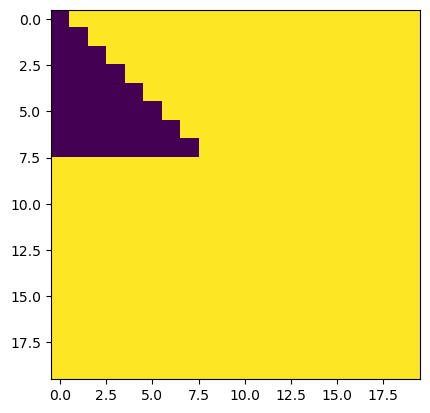

embeddings right after transformer forward tensor([[[-0.4502,  0.0157, -0.7128,  1.0435, -1.3964,  1.5000],
         [ 0.0454, -0.4041, -0.6575,  1.0880, -1.4878,  1.4160],
         [ 0.2126, -0.9419, -0.5434,  1.2524, -1.2555,  1.2758],
         [-0.0529, -1.1244, -0.4663,  1.4234, -1.0001,  1.2203],
         [-0.5030, -0.8702, -0.4714,  1.5033, -0.9361,  1.2772],
         [-0.7859, -0.3599, -0.5639,  1.4286, -1.0540,  1.3352],
         [-0.6008, -0.0656, -0.6753,  1.2985, -1.2997,  1.3429],
         [-0.0594, -0.3293, -0.6952,  1.2407, -1.4663,  1.3096],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  

In [7]:
context_length = 20
d_embed = 6
n_extra_thoughts = 1 #

y = ThoughtsFormer(thought_length=n_extra_thoughts, vocab_size=5, max_context_length=context_length, num_layers=1, d_embed=d_embed,n_head=1, verbose=True,dropout=0)


token_count = 8
real_token_count = token_count

tokens = torch.cat((torch.ones(1,token_count,d_embed), torch.zeros(1,context_length - token_count, d_embed)), dim=1)
padding_arr = torch.cat((torch.zeros(1,token_count),torch.ones(1,context_length - token_count)), dim=-1)

y_embeddings = y.forward_ppo(tokens, padding_arr,0)
# get_logits_for_sequences(token_count, y_embeddings, n_extra_thoughts)

In [8]:
y_embeddings

tensor([[[ 1.1624, -0.0141, -1.0231,  0.3266,  0.6928],
         [ 1.1951, -0.0971, -0.9133,  0.0833,  0.7577],
         [ 1.2024, -0.1614, -0.7602, -0.1139,  0.7183],
         [ 1.1957, -0.1226, -0.7297, -0.0457,  0.5896],
         [ 1.2037, -0.0079, -0.8705,  0.2255,  0.4994],
         [ 1.2063,  0.0725, -1.0326,  0.4331,  0.5230],
         [ 1.2148,  0.0616, -1.0846,  0.4058,  0.6260],
         [ 1.2395, -0.0192, -1.0031,  0.1738,  0.7255]]],
       grad_fn=<IndexBackward0>)

In [9]:
loss_fn = F.cross_entropy


class env():
    def __init__(self,  token_sequence, thought_length):
        vocab_size = 30000
        self.thoughtsformer = ThoughtsFormer(thought_length=thought_length, vocab_size=vocab_size, max_context_length=10, num_layers=5)
        
        self.x, self.y = self.extract_labels_and_targets_from(token_sequence)
        
        self.thought_length = thought_length
        self.thoughts_taken = 0
    
    def extract_labels_and_targets_from(self, token_sequence):

        inputs = self.tokenizer(token_sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.gpt2_model(**inputs)
        
        x = outputs.last_hidden_state.squeeze(0)[:-1]  # All but last token
        y = inputs.input_ids.squeeze()[1:]  # All but first token ID
        
        return x, y
    
    def reset(self):
        self.thoughts_taken = 0
    def step(self, action_embeddings, state_embeddings):
        self.thoughts_taken += 1
        next_embeddings = action_embeddings
        if self.thoughts_taken != self.thought_length:
            next_state_embeddings = self.thoughtsformer.insert_thoughts(next_embeddings, state_embeddings, self.thoughts_taken + 1)

        return self.reward(next_state_embeddings, self.thoughts_taken)
    
    def reward(self, next_state_embeddings, thoughts_taken):
        
        
        if thoughts_taken == self.thought_length:
            logits = self.thoughtsformer.get_logits_for_sequences(next_state_embeddings, thoughts_taken)
            loss_fn(logits, targets=self.y)
        else:
            return 0